# Baysean Sructural Time Series Tutorial 1: Nowcasting

Consider sea surface temperature SST of the first 30 meters around Gilbralter, shown below

Parsed with column specification:
cols(
  X1 = col_integer(),
  `Unnamed: 0` = col_integer(),
  `Unnamed: 0.1` = col_integer(),
  `Unnamed: 0.1.1` = col_integer(),
  `Unnamed: 0.1.1.1` = col_integer(),
  `Unnamed: 0.1.1.1.1` = col_integer(),
  `Unnamed: 0.1.1.1.1.1` = col_double(),
  tempMean = col_double(),
  psalMean = col_double(),
  tempStd = col_double(),
  psalStd = col_double(),
  startDate = col_date(format = ""),
  endDate = col_date(format = ""),
  nProf = col_double()
)


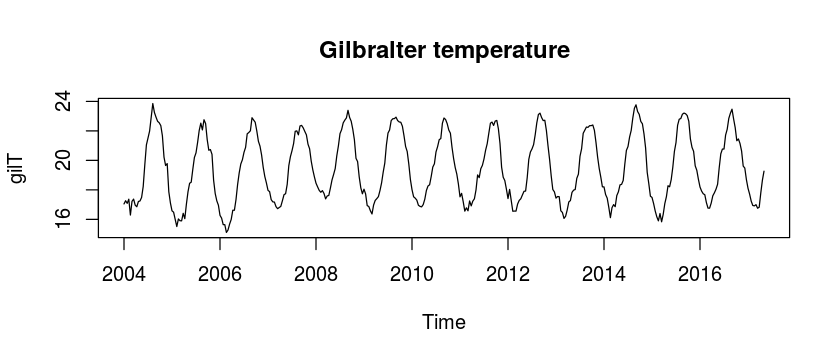

In [30]:
library(Boom)
library(zoo)
library(bsts)     # load the bsts package
library(readr)
options( warn = -1 )
options(repr.plot.width=7, repr.plot.height=3)
gilbralter <- read_csv("gilbralter.csv")
gilT <- ts(gilbralter$tempMean, start=c(2004,1,13), end=c(2017, 11, 25), frequency=30)
plot(gilT, main="Gilbralter temperature")

SST can be modeled as $y_t$. We can see it has a time series behavior, lets model this as $y_{t-\tau}$. We are directly reading the data source $x_t$. Note that $x_t$ may contain false measurements and outliers!. We can model $y_t$ with three components: trend $\mu_t$, seasonal pattern $\tau_t$ and a regression component $\beta x_t$. This is modeled by four equations.

$$
y_t = \mu_t + \tau_t + \beta^Tx_t + \epsilon_t
$$

$$
\mu_{n+1} = \mu_t + \delta_t + \eta_{0t}
$$

$$
\delta_{t+1} = \delta_t + \eta_{1t}
$$

$$
\tau_{t+1} = -\Sigma_{s=1}^{s-1} \tau_t + \eta_{2t}
$$

We model $\delta_t$ as the slope of a linear trend, and can see that the slope evolves as a random walk (third equation), making the second equation an integrated random walk with an extra drift term. 

For now $\eta_{nt}, \epsilon_{t}$ are Normal independent distribtions.

Suppose that we are interested in 'nowcasting'. The local linear trend is good for this is if you think the time series is trending in a particular direction, and you want to include this recent trend in future observations.

Let's ignore the regression component $\beta^T x_t$ for now and fit a bsts model with just the trend and seasonal components.

We use the bsts library. But first a little more theory on Structural time series models...

### Structural Time Series

Consider an **observation equation** relating an observation $y_t$ to a system state $\alpha_t$.

$$
y_t = Z_t^T \alpha_t + \epsilon_t
$$

Also consider that the state $\alpha_t$ evolves through time as described by the **transition equation**

$$
\alpha_{t-1} = T_t \alpha + R_t \eta_t
$$

Parameters $Z_t^T$, $T_t$, and $R_t$ are **structural parameters**. Those greek terms at the end represent normally distributed random errors at each time step, $t$. 

$$
\epsilon_t ~ N(0, \sigma^2)
$$

$$
\eta_t ~ N(0, \zeta^2)
$$

We assume that $\epsilon_t$ and $\eta_t$ are independent of everything.

### Fitting a Structural Time Series

To model $y_t = Z_t^T \alpha_t + \epsilon_t$ with $\alpha_{t-1} = T_t \alpha + R_t \eta_t$, we first need to specify the contents of the **latent state vector** $\alpha_t$. R's has a **Baysean Sturctural Time Series** library called bsts that handles this with the **state specification object** *ss*. 

In our case, we are interested in only modeling trend and seasonal components. This is handled by the code below...

In [35]:
nseasons = 30 #A 12 day aggregate has 30 samples per period.
ss <- AddLocalLinearTrend(list(), gilT)
ss <- AddSeasonal(ss, gilT, nseasons=nseasons)

Here some magic happens inside of the _bsts_ function.

In [36]:
model1 <- bsts(gilT,
               state.specification=ss,
               niter = 1000)

=-=-=-=-= Iteration 0 Sun Feb 25 10:34:26 2018 =-=-=-=-=
=-=-=-=-= Iteration 100 Sun Feb 25 10:34:30 2018 =-=-=-=-=
=-=-=-=-= Iteration 200 Sun Feb 25 10:34:34 2018 =-=-=-=-=
=-=-=-=-= Iteration 300 Sun Feb 25 10:34:38 2018 =-=-=-=-=
=-=-=-=-= Iteration 400 Sun Feb 25 10:34:43 2018 =-=-=-=-=
=-=-=-=-= Iteration 500 Sun Feb 25 10:34:47 2018 =-=-=-=-=
=-=-=-=-= Iteration 600 Sun Feb 25 10:34:52 2018 =-=-=-=-=
=-=-=-=-= Iteration 700 Sun Feb 25 10:34:57 2018 =-=-=-=-=
=-=-=-=-= Iteration 800 Sun Feb 25 10:35:01 2018 =-=-=-=-=
=-=-=-=-= Iteration 900 Sun Feb 25 10:35:05 2018 =-=-=-=-=


We don't know what is happening under the hood; but behold, we have a seasonal and trend models!

In [39]:
names(model1)

[1] "sigma.obs"                  "sigma.trend.level"         
 [3] "sigma.trend.slope"          "sigma.seasonal.30"         
 [5] "final.state"                "state.contributions"       
 [7] "one.step.prediction.errors" "log.likelihood"            
 [9] "has.regression"             "state.specification"       
[11] "prior"                      "timestamp.info"            
[13] "model.options"              "family"                    
[15] "niter"                      "original.series"

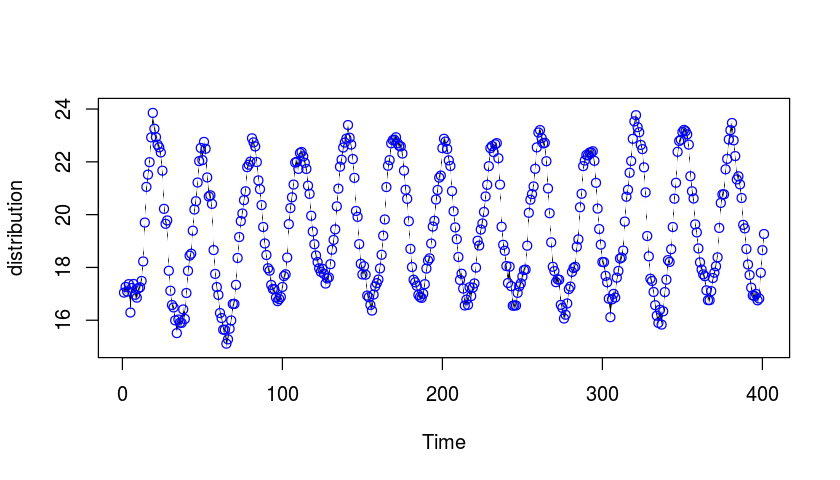

In [37]:
options(repr.plot.width=7, repr.plot.height=4)
plot(model1)

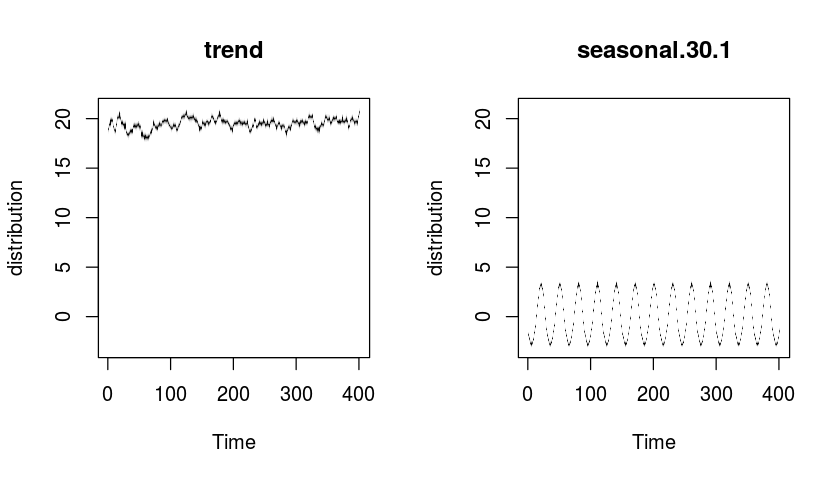

In [38]:
plot(model1, "components")

From here we can perform nowcasting 12 time steps in the future (144 days) with the following code.

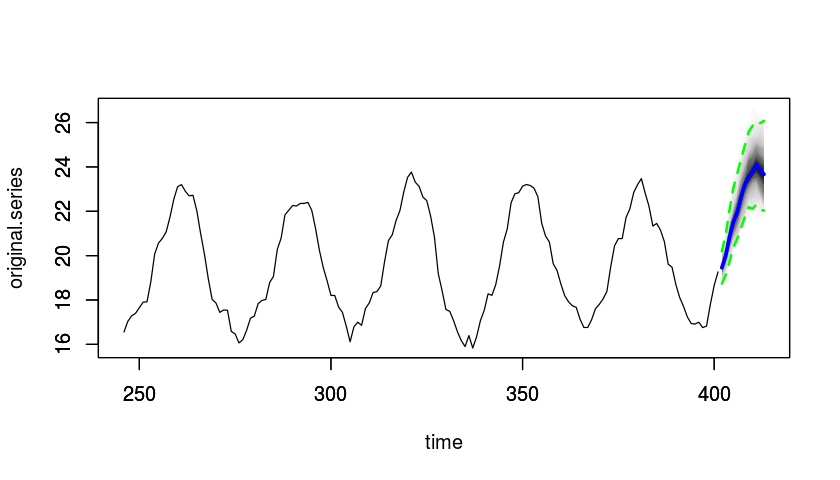

In [41]:
pred1 <- predict(model1, horizon = 12)
plot(pred1, plot.original = 156)

In [10]:
plot(model1, "help")